<pre>
█▄▀ █░░ ▄▀█ █▀ █▄█ █▀▀ █ █▄▀ ▄▀█ ▀█▀ █▀█ █▀█   █▄▄ ▄▀█ ░░█ █▀▀ █▀ █▀█ █░█░█ █▀ █▄▀ █   
█░█ █▄▄ █▀█ ▄█ ░█░ █▀░ █ █░█ █▀█ ░█░ █▄█ █▀▄   █▄█ █▀█ █▄█ ██▄ ▄█ █▄█ ▀▄▀▄▀ ▄█ █░█ █   

▀█▀ █░█ █▀▀   █▀▀ █▀█ █▀▀ ▄▀█ ▀█▀   █▀▄▀█ █▀█ █▀▀   █▀▀ █▀▄ █ ▀█▀ █ █▀█ █▄░█
░█░ █▀█ ██▄   █▄█ █▀▄ ██▄ █▀█ ░█░   █░▀░█ █▄█ █▄█   ██▄ █▄▀ █ ░█░ █ █▄█ █░▀█ 
(AKA I copied it from someone smarter than both me and chatGPT vomit edition)
</pre>

Fajny artykuł na którym oparłem dużą część tego projektu:
Artykuł "Naive Bayes and Hyperparameter Optimization" przedstawia w sposób przystępny podstawy klasyfikatora Naive Bayes oraz techniki optymalizacji hiperparametrów. Obejmuje zarówno teoretyczne aspekty, jak i praktyczne przykłady implementacji w Pythonie, co czyni go wartościowym źródłem wiedzy dla osób zainteresowanych uczeniem maszynowym.

Link do artykułu: [Naive Bayes and Hyperparameter Optimization](https://bait509-ubc.github.io/BAIT509/lectures/lecture6.html)

### Zalety i wady naiwnego klasyfikatora Bajesowskiego w kontekście naszego projektu

**Zalety**

- **Mniejsza złożoność:** Naïve Bayes jest prostszy w porównaniu do innych klasyfikatorów. 
- **Dobra skalowalność:** Jest szybki i efektywny, a także wymaga niewielkiej ilości pamięci.
- **Obsługa danych o wysokiej wymiarowości:** Sprawdza się w przypadkach takich jak klasyfikacja dokumentów, gdzie liczba wymiarów jest wysoka.

**Wady**

- **Zjawisko zerowej częstości:** Występuje, gdy zmienna kategoryczna nie istnieje w zbiorze treningowym, co prowadzi do zerowego prawdopodobieństwa warunkowego. Problem ten można rozwiązać za pomocą wygładzania Laplace’a.
- **Nierealistyczne założenie podstawowe:** Założenie o niezależności warunkowej nie zawsze jest spełnione, co może prowadzić do błędnych klasyfikacji.

**Zastosowania klasyfikatora Naïve Bayes**

- **Filtrowanie spamu:** Jedno z najpopularniejszych zastosowań, gdzie Naïve Bayes służy do klasyfikacji wiadomości jako spam.
- **Klasyfikacja dokumentów:** Używany do klasyfikacji treści, np. artykułów na stronach mediów informacyjnych.
- **Analiza sentymentu:** Pomaga w zrozumieniu opinii i postaw wobec produktów i marek.
- **Przewidywanie stanów umysłowych:** Wykorzystywany w analizie danych fMRI do przewidywania stanów poznawczych ludzi.
źródło IBM


| Nazwa klasyfikatora      | Opis                                                                                       | Założenie                                                     | Nadaje się do                                                    | Przyjęto (wyjaśnienie)    |
|--------------------------|--------------------------------------------------------------------------------------------|---------------------------------------------------------------|------------------------------------------------------------------|--------------------------|
| Gaussian Naive Bayes     | Zakłada normalny (gaussowski) rozkład cech w każdej klasie.                                | Cechy mają ciągły rozkład gaussowski.                         | Numeryczne cechy, które są w przybliżeniu normalnie rozłożone.    |✅|
| Multinomial Naive Bayes  | Zaprojektowany dla dyskretnych danych opartych na liczeniu (np. dane tekstowe reprezentowane przez częstotliwość słów). | Cechy są liczbami wystąpień w różnych klasach.                 | Klasyfikacja tekstów, kategoryzacja dokumentów, analiza sentymentu. |❌✅|
| Complement Naive Bayes   | Zakłada cechy binarne lub logiczne, wskazujące obecność lub brak cechy.                     | Cechy są binarne (0/1).                                        | Klasyfikacja tekstów, klasyfikacja danych binarnych.              |❌|
| Categorical Naive Bayes  | Obsługuje cechy kategoryczne, które mogą przyjmować dyskretne wartości bez zakładania żadnego określonego rozkładu. | Cechy są zmiennymi kategorycznymi.                             | Klasyfikacja tekstów, systemy rekomendacyjne z danymi kategorycznymi. |✅|
| Bernoulli Naive Bayes    | Zakłada cechy binarne lub logiczne, wskazujące obecność lub brak cechy.                     | Cechy są binarne (0/1).                                        | Klasyfikacja tekstów, klasyfikacja danych binarnych.              |❌|


In [2037]:
# All the Data Science Gang in da hood 
import math
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns

# Scikit-learn libraries
from sklearn.impute import SimpleImputer
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
from sklearn.model_selection import GridSearchCV, KFold, cross_validate, train_test_split, RandomizedSearchCV
from sklearn.naive_bayes import GaussianNB, MultinomialNB, ComplementNB, BernoulliNB, CategoricalNB
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import MinMaxScaler, StandardScaler
from sklearn.svm import SVC
from sklearn.utils.class_weight import compute_class_weight
from imblearn.over_sampling import SMOTE, ADASYN
from imblearn.combine import SMOTETomek, SMOTEENN


#debugging stuff
from typing import Tuple, Optional, Dict, Any
import logging

# Configure logging
logging.basicConfig(level=logging.INFO, format='%(asctime)s - %(levelname)s - %(message)s')

# Data Initialization Documentation

In [2038]:
def initialize_data(scaler_type: Optional[str] = None) -> Tuple[pd.DataFrame, pd.Series]:
    # Load data from CSV files
    X = pd.read_csv('wineData.csv')
    y = pd.read_csv('wineRatings.csv')
    y = y.values.ravel()
    
    # Log data information
    logging.info(f"X shape: {X.shape}, y shape: {y.shape}")

    # Preprocess data using the specified scaler
    if scaler_type in ["minmax", "standard"]:
        scaler = MinMaxScaler() if scaler_type == "minmax" else StandardScaler()
        X = scaler.fit_transform(X)
        logging.info(f"Data scaled using {scaler_type} scaler.")
    else:
        logging.info("No scaling applied.")

    return X, y


# Common Functions


In [2039]:

def sampling_strategy(y):
    unique, counts = np.unique(y, return_counts=True)
    max_count = max(counts)
    return {class_label: max(int(0.10 * max_count), count) for class_label, count in zip(unique, counts)}

def initialize_and_split_data(scaler_type: str, method: str = 'none') -> Tuple[np.ndarray, np.ndarray, np.ndarray, np.ndarray]:
    X, y = initialize_data(scaler_type)
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)
    if method == 'smote':
        strategy = sampling_strategy(y_train)
        oversampler = SMOTE(sampling_strategy=strategy, k_neighbors=2, random_state=42)
        X_train, y_train = oversampler.fit_resample(X_train, y_train)
        logging.info(f"Applied {method} to handle class imbalance in the training data.")
    return X_train, X_test, y_train, y_test

def evaluate_model(X_train: np.ndarray, y_train: np.ndarray, model: Any, cv_splits: int = 5, random_state: int = 2137) -> Tuple[float, np.ndarray, np.ndarray, np.ndarray, list]:
    kfold = KFold(n_splits=cv_splits, shuffle=True, random_state=random_state)
    accuracy_scores = []
    
    for train_index, test_index in kfold.split(X_train):
        X_fold_train, X_fold_test = X_train[train_index], X_train[test_index]
        y_fold_train, y_fold_test = y_train[train_index], y_train[test_index]

        model.fit(X_fold_train, y_fold_train)
        y_pred = model.predict(X_fold_test)
        accuracy = accuracy_score(y_fold_test, y_pred)
        accuracy_scores.append(accuracy)
        logging.info(f"Accuracy for this fold: {accuracy * 100:.2f}%")

    mean_accuracy = np.mean(accuracy_scores)
    return mean_accuracy, X_fold_test, y_fold_test, y_pred, accuracy_scores

def optimize_hyperparameters(X_train: np.ndarray, y_train: np.ndarray, estimator: Any, param_grid: Dict[str, Any], n_iter: int = 100, cv_splits: int = 5, random_state: int = 42) -> Dict[str, Any]:
    random_search = RandomizedSearchCV(estimator, param_distributions=param_grid, n_iter=n_iter, cv=cv_splits, scoring='accuracy', random_state=random_state)
    random_search.fit(X_train, y_train)
    logging.info(f"Best accuracy score: {random_search.best_score_ * 100:.2f}%")
    return random_search.best_params_

def cross_validation_with_optimized_hyperparameters(X_train: np.ndarray, y_train: np.ndarray, model: Any, best_params: Dict[str, Any], cv_splits: int = 5, random_state: int = 42, model_name: str = 'GaussianNB') -> Dict[str, Any]:
    model.set_params(**best_params)
    pipe = make_pipeline(model)
    kfold = KFold(n_splits=cv_splits, shuffle=True, random_state=random_state)
    cv_results = cross_validate(pipe, X_train, y_train, cv=kfold, return_train_score=True)
    return cv_results

def evaluate_initial_model(X: np.ndarray, y: np.ndarray, model: Any) -> Tuple[float, np.ndarray, np.ndarray, np.ndarray, list]:
    mean_accuracy, X_fold_test, y_fold_test, y_pred, accuracy_scores = evaluate_model(X, y, model)
    logging.info(f"Mean accuracy score over all folds: {mean_accuracy * 100:.2f}%")
    logging.info(f"Accuracy for the last fold: {accuracy_scores[-1] * 100:.2f}%")
    return mean_accuracy, X_fold_test, y_fold_test, y_pred, accuracy_scores

## Reports and plots


In [2040]:

def generate_report(y_test: Any, y_pred: Any) -> Dict[str, Any]:
    report = classification_report(y_test, y_pred, output_dict=True, zero_division=1)
    logging.info("Classification report:\n%s", classification_report(y_test, y_pred, zero_division=1))
    logging.info("Confusion matrix:\n%s", confusion_matrix(y_test, y_pred))
    return report

def plot_actual_vs_predicted(y_test: Any, y_pred: Any, ax: plt.Axes) -> None:
    pd.DataFrame({'Actual': y_test, 'Predicted': y_pred}).plot(ax=ax, marker='o')
    ax.set_title('Actual vs Predicted values')
    ax.set_xlabel('Index')
    ax.set_ylabel('Values')
    ax.legend(['Actual', 'Predicted'])

def plot_confusion_matrix(y_test: Any, y_pred: Any, ax: plt.Axes) -> None:
    cm = confusion_matrix(y_test, y_pred)
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', ax=ax)
    ax.set_title('Confusion Matrix')
    ax.set_xlabel('Predicted')
    ax.set_ylabel('Actual')

def plot_classification_report(report: Dict[str, Any], ax: plt.Axes) -> None:
    report_df = pd.DataFrame(report).transpose().drop(columns='support')
    report_df.plot(kind='bar', ax=ax)
    ax.set_title('Classification Report Metrics')
    ax.set_xlabel('Metrics')
    ax.set_ylabel('Score')
    ax.set_ylim(0, 1)
    ax.legend(loc='lower right')

def display_plots(y_fold_test: np.ndarray, y_pred: np.ndarray, report: Dict[str, Any], cv_results: Dict[str, Any], accuracy_without_optimization: float, accuracy_with_optimization: float) -> None:
    fig, axs = plt.subplots(3, 2, figsize=(16, 16))
    
    plot_actual_vs_predicted(y_fold_test, y_pred, axs[0, 0])
    plot_confusion_matrix(y_fold_test, y_pred, axs[0, 1])
    plot_classification_report(report, axs[1, 0])
    
    axs[1, 1].plot(cv_results['test_score'], label='Test Score')
    axs[1, 1].plot(cv_results['train_score'], label='Train Score')
    axs[1, 1].set_title('Cross-validation Results with Optimized Hyperparameters')
    axs[1, 1].set_xlabel('Fold Index')
    axs[1, 1].set_ylabel('Accuracy')
    axs[1, 1].legend()

    axs[2, 0].bar(['Without Optimization', 'With Optimization'], [accuracy_without_optimization, accuracy_with_optimization])
    axs[2, 0].set_title('Comparison of Model Performance')
    axs[2, 0].set_ylabel('Mean Accuracy Score')
    
    plt.tight_layout()
    plt.show()

2024-05-30 09:20:07,589 - INFO - X shape: (1503, 5), y shape: (1503,)
2024-05-30 09:20:07,593 - INFO - Data scaled using standard scaler.
2024-05-30 09:20:07,593 - INFO - Data initialization and splitting complete.
2024-05-30 09:20:07,607 - INFO - Accuracy for this fold: 58.29%
2024-05-30 09:20:07,609 - INFO - Accuracy for this fold: 60.19%
2024-05-30 09:20:07,609 - INFO - Accuracy for this fold: 56.67%
2024-05-30 09:20:07,619 - INFO - Accuracy for this fold: 60.48%
2024-05-30 09:20:07,625 - INFO - Accuracy for this fold: 51.90%
2024-05-30 09:20:07,626 - INFO - Mean accuracy score over all folds: 57.51%
2024-05-30 09:20:07,627 - INFO - Accuracy for the last fold: 51.90%
2024-05-30 09:20:07,639 - INFO - Classification report:
              precision    recall  f1-score   support

           4       0.14      0.14      0.14         7
           5       0.59      0.68      0.63        95
           6       0.47      0.40      0.44        84
           7       0.43      0.39      0.41     

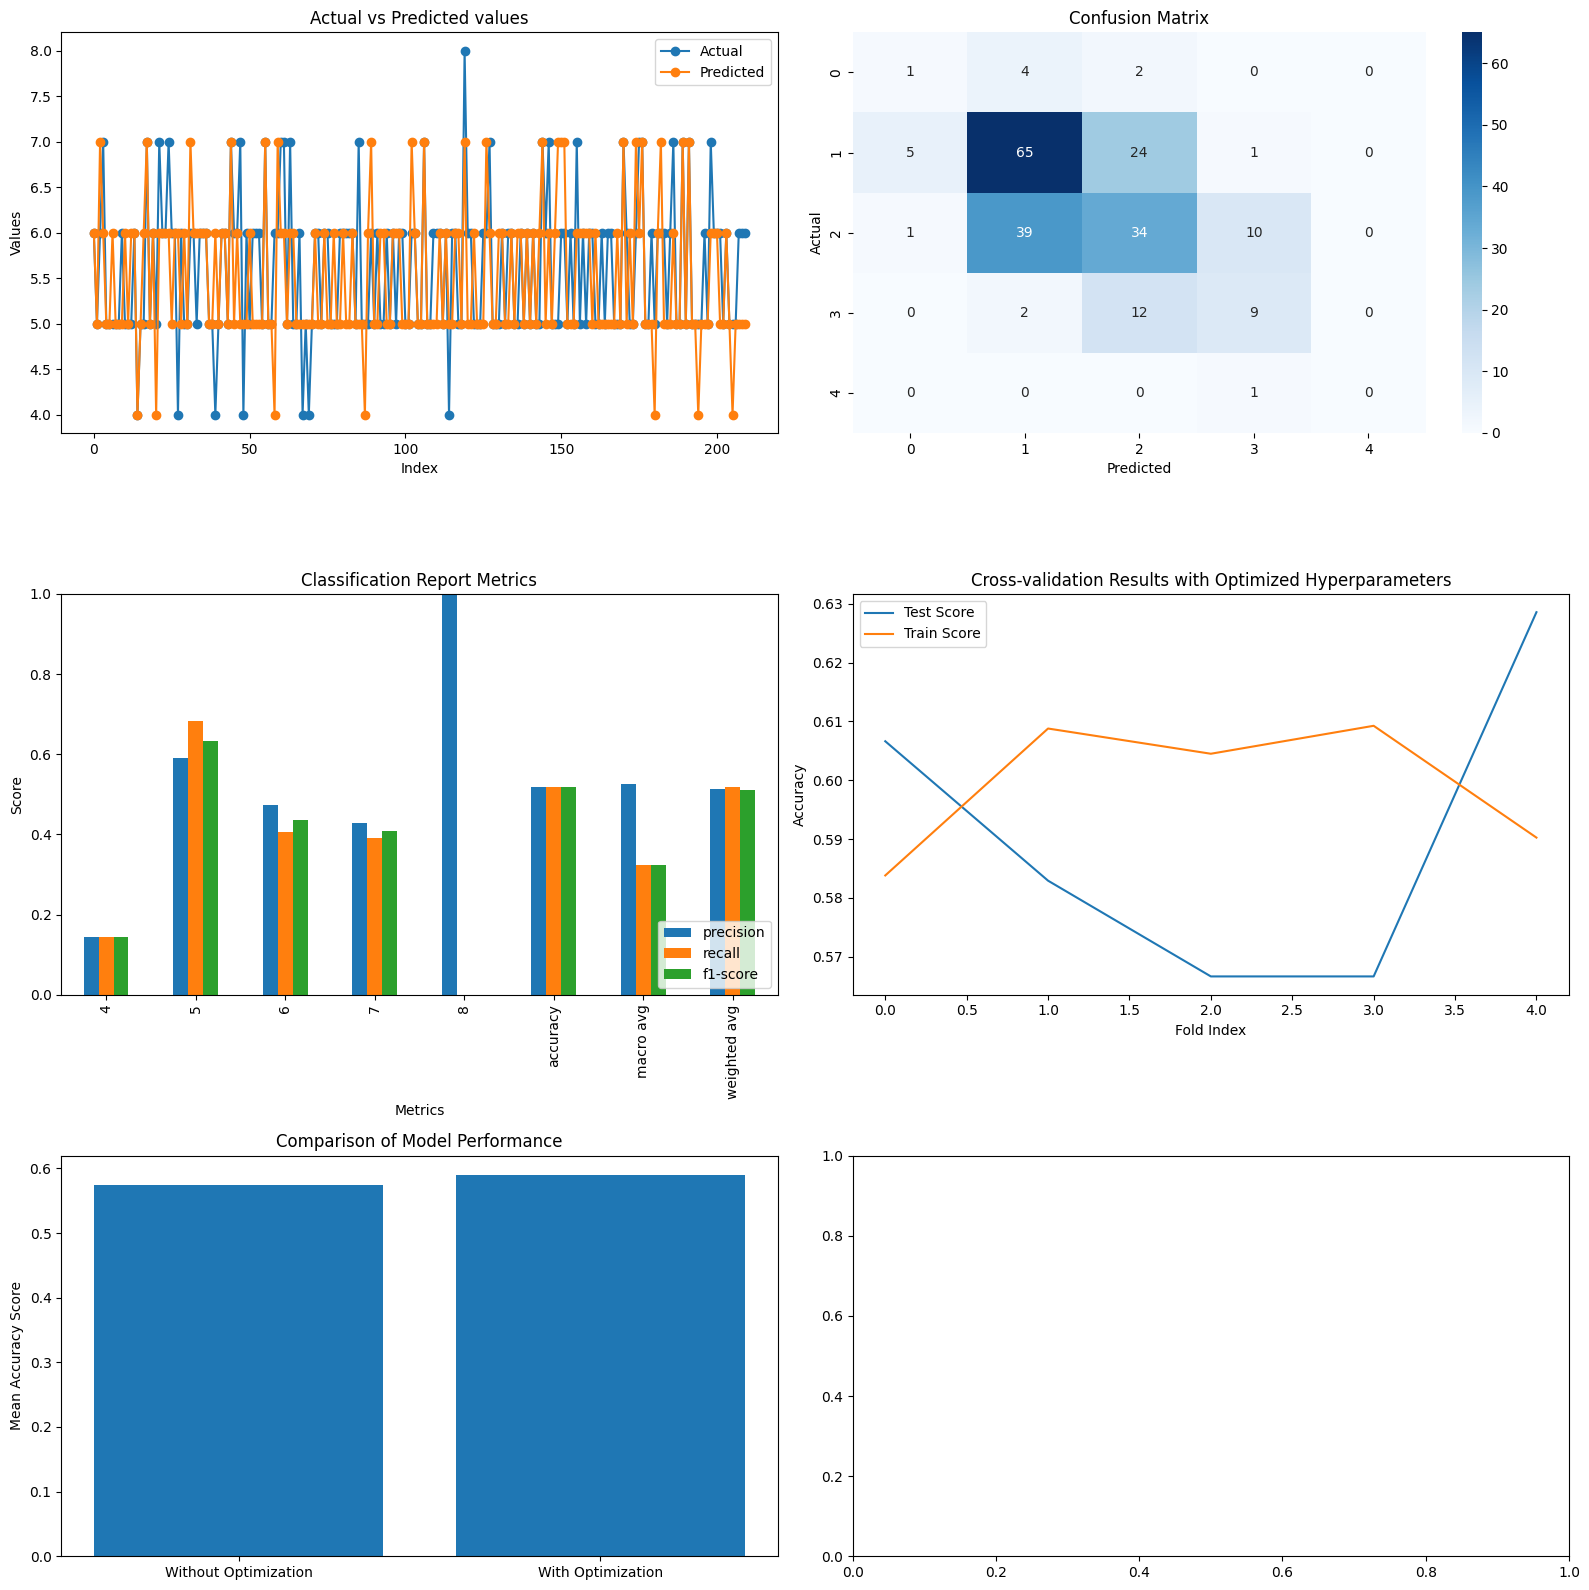

In [2041]:

def perform_hyperparameter_optimization(X_train: np.ndarray, y_train: np.ndarray, model: Any) -> Dict[str, Any]:
    param_grid = {'var_smoothing': np.logspace(0, -9, num=100)}
    best_params = optimize_hyperparameters(X_train, y_train, model, param_grid)
    logging.info(f"Best parameters: {best_params}")
    return best_params

def cross_validate_with_optimized_params(X_train: np.ndarray, y_train: np.ndarray, model: Any, best_params: Dict[str, Any]) -> Dict[str, Any]:
    cv_results = cross_validation_with_optimized_hyperparameters(X_train, y_train, model, best_params, model_name='GaussianNB')
    logging.info(f"Cross-validation results: {cv_results}")
    return cv_results

def gaussian_naive_bayes_main():
    try:
        # Initialize and split data
        X_train, X_test, y_train, y_test = initialize_and_split_data("standard", 'none')
        logging.info("Data initialization and splitting complete.")

        # Initial Model Evaluation
        gnb = GaussianNB()
        mean_accuracy, X_fold_test, y_fold_test, y_pred, accuracy_scores = evaluate_initial_model(X_train, y_train, gnb)
        accuracy_without_optimization = mean_accuracy

        # Report Generation for the Last Fold
        report = generate_report(y_fold_test, y_pred)

        # Hyperparameter Tuning
        best_params = perform_hyperparameter_optimization(X_train, y_train, gnb)

        # Cross-validation with the optimized hyperparameters
        cv_results = cross_validate_with_optimized_params(X_train, y_train, gnb, best_params)
        accuracy_with_optimization = np.mean(cv_results['test_score'])

        # Display plots
        display_plots(y_fold_test, y_pred, report, cv_results, accuracy_without_optimization, accuracy_with_optimization)

    except Exception as e:
        logging.error("An error occurred during model evaluation and plotting.", exc_info=True)

if __name__ == "__main__":
    gaussian_naive_bayes_main()

# Complement Naive Bayes

2024-05-30 09:20:10,140 - INFO - X shape: (1503, 5), y shape: (1503,)
2024-05-30 09:20:10,140 - INFO - Data scaled using minmax scaler.


2024-05-30 09:20:10,140 - INFO - Data initialization and splitting complete.
2024-05-30 09:20:10,149 - INFO - Accuracy for this fold: 56.40%
2024-05-30 09:20:10,149 - INFO - Accuracy for this fold: 50.24%
2024-05-30 09:20:10,149 - INFO - Accuracy for this fold: 55.71%
2024-05-30 09:20:10,155 - INFO - Accuracy for this fold: 56.19%
2024-05-30 09:20:10,159 - INFO - Accuracy for this fold: 56.67%
2024-05-30 09:20:10,159 - INFO - Mean accuracy score over all folds: 55.04%
2024-05-30 09:20:10,159 - INFO - Accuracy for the last fold: 56.67%
2024-05-30 09:20:10,169 - INFO - Classification report:
              precision    recall  f1-score   support

           4       0.00      0.00      0.00         7
           5       0.65      0.73      0.69        95
           6       0.52      0.57      0.54        84
           7       0.40      0.09      0.14        23
           8       1.00      0.00      0.00         1

    accuracy                           0.57       210
   macro avg       0.51

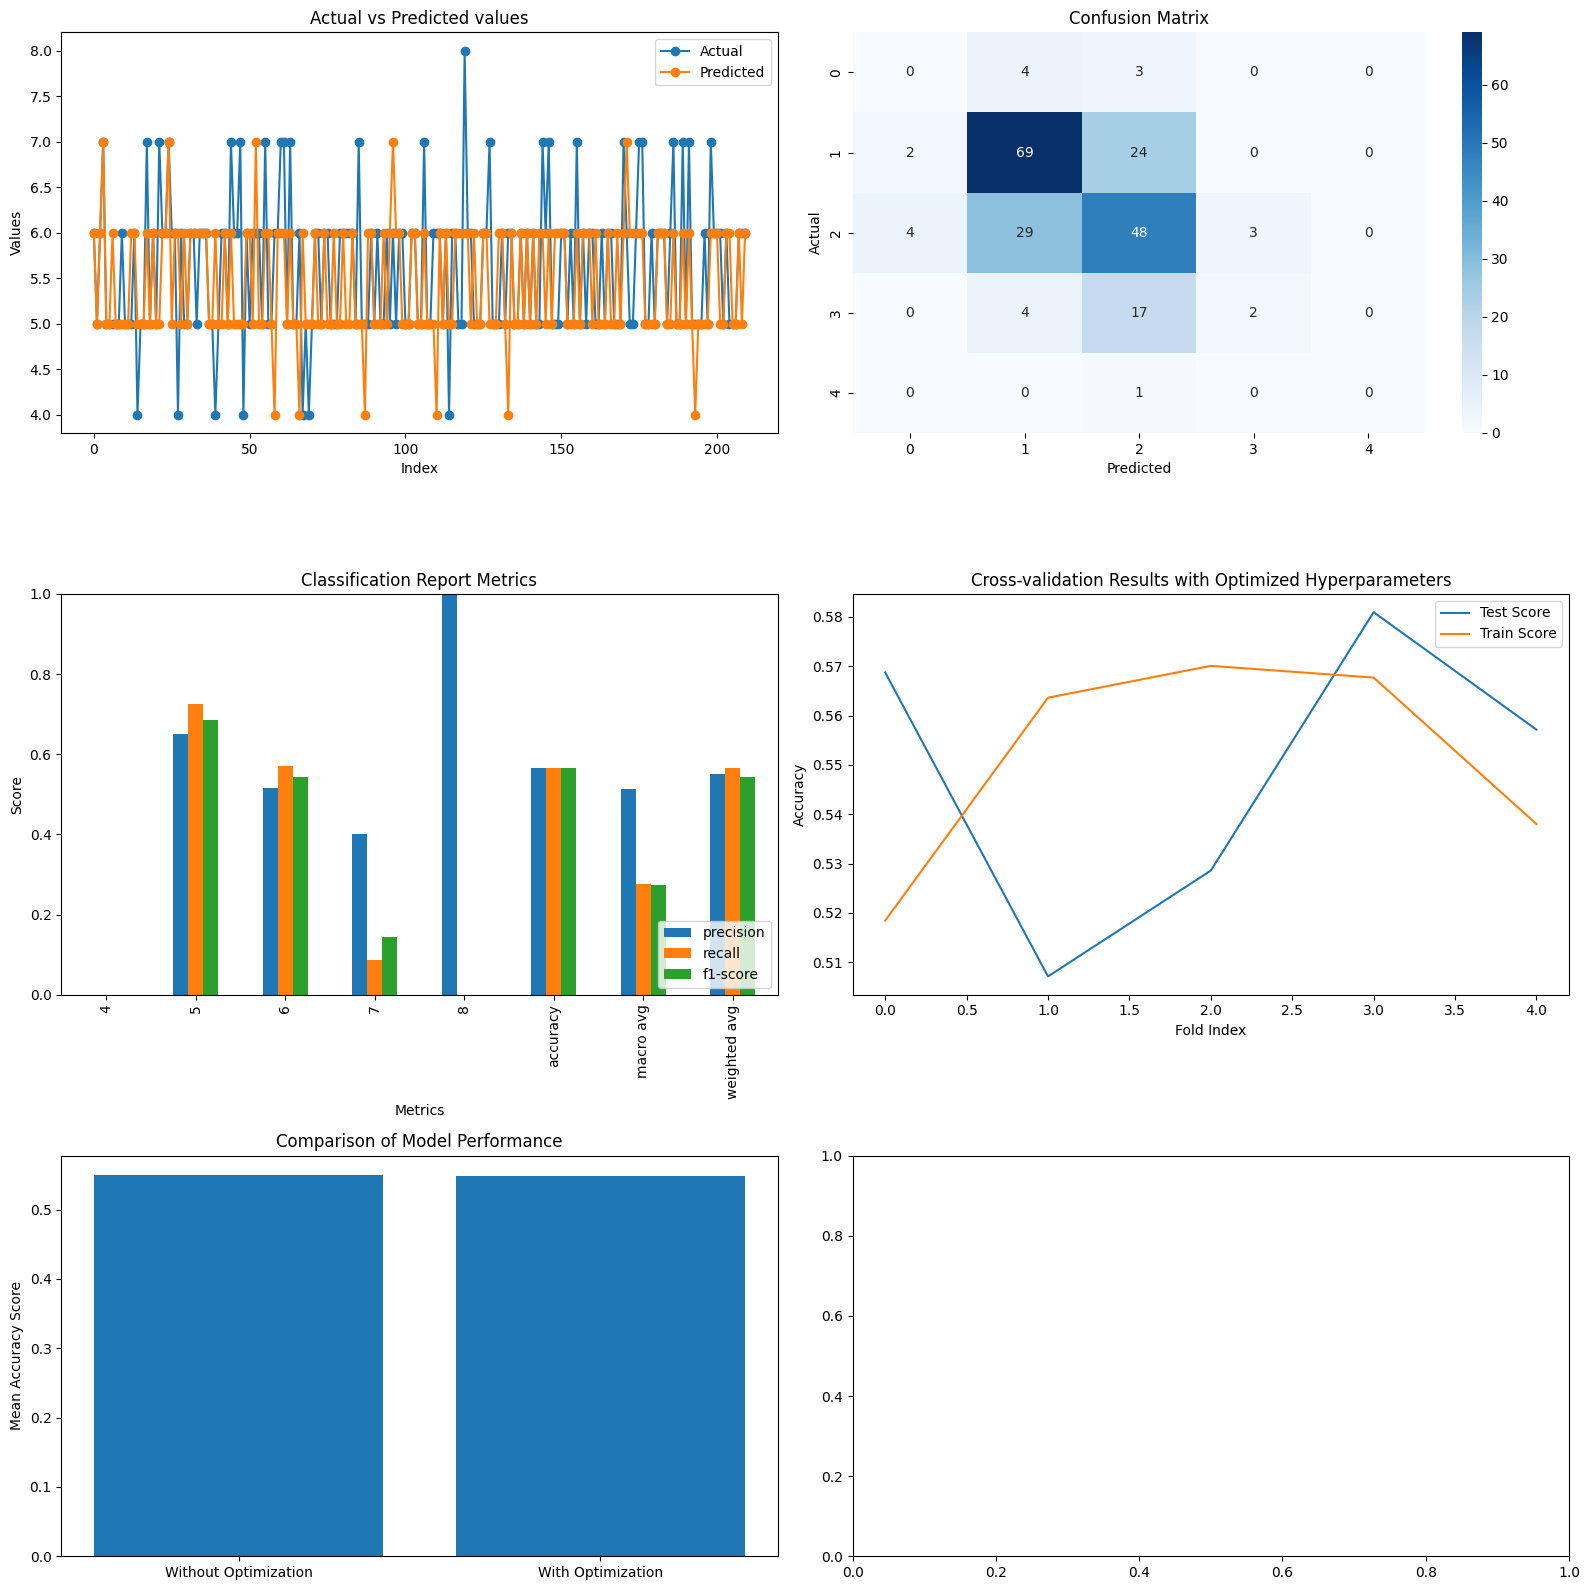

In [2042]:
import numpy as np
import logging
from typing import Any, Dict
from sklearn.naive_bayes import ComplementNB

def perform_hyperparameter_optimization(X_train: np.ndarray, y_train: np.ndarray, model: Any) -> Dict[str, Any]:
    param_grid = {
        'alpha': np.logspace(-3, 1, num=100),
        'force_alpha': [True, False],
        'fit_prior': [True, False],
        'norm': [True, False]
    }
    best_params = optimize_hyperparameters(X_train, y_train, model, param_grid)
    logging.info(f"Best parameters: {best_params}")
    return best_params

def cross_validate_with_optimized_params(X_train: np.ndarray, y_train: np.ndarray, model: Any, best_params: Dict[str, Any]) -> Dict[str, Any]:
    cv_results = cross_validation_with_optimized_hyperparameters(X_train, y_train, model, best_params, model_name='ComplementNB')
    logging.info(f"Cross-validation results: {cv_results}")
    return cv_results

def complement_naive_bayes_main():
    try:
        # Initialize and split data
        X_train, X_test, y_train, y_test = initialize_and_split_data("minmax", 'none')
        logging.info("Data initialization and splitting complete.")

        # Initial Model Evaluation
        cnb = ComplementNB()
        mean_accuracy, X_fold_test, y_fold_test, y_pred, accuracy_scores = evaluate_initial_model(X_train, y_train, cnb)
        accuracy_without_optimization = mean_accuracy

        # Report Generation for the Last Fold
        report = generate_report(y_fold_test, y_pred)

        # Hyperparameter Tuning
        best_params = perform_hyperparameter_optimization(X_train, y_train, cnb)

        # Cross-validation with the optimized hyperparameters
        cv_results = cross_validate_with_optimized_params(X_train, y_train, cnb, best_params)
        accuracy_with_optimization = np.mean(cv_results['test_score'])

        # Display plots
        display_plots(y_fold_test, y_pred, report, cv_results, accuracy_without_optimization, accuracy_with_optimization)

    except Exception as e:
        logging.error("An error occurred during model evaluation and plotting.", exc_info=True)

if __name__ == "__main__":
    complement_naive_bayes_main()


# Multinominal Naive Bayes

2024-05-30 09:20:12,150 - INFO - X shape: (1503, 5), y shape: (1503,)
2024-05-30 09:20:12,153 - INFO - Data scaled using standard scaler.
2024-05-30 09:20:12,155 - INFO - Data initialization and splitting complete.
2024-05-30 09:20:12,159 - INFO - Accuracy for this fold: 59.24%
2024-05-30 09:20:12,159 - INFO - Accuracy for this fold: 60.19%
2024-05-30 09:20:12,159 - INFO - Accuracy for this fold: 55.24%
2024-05-30 09:20:12,170 - INFO - Accuracy for this fold: 51.90%
2024-05-30 09:20:12,174 - INFO - Accuracy for this fold: 50.48%
2024-05-30 09:20:12,176 - INFO - Mean accuracy score over all folds: 55.41%
2024-05-30 09:20:12,176 - INFO - Accuracy for the last fold: 50.48%
2024-05-30 09:20:12,189 - INFO - Classification report:
              precision    recall  f1-score   support

           4       1.00      0.00      0.00         7
           5       0.61      0.69      0.65        95
           6       0.44      0.37      0.40        84
           7       0.29      0.39      0.33     

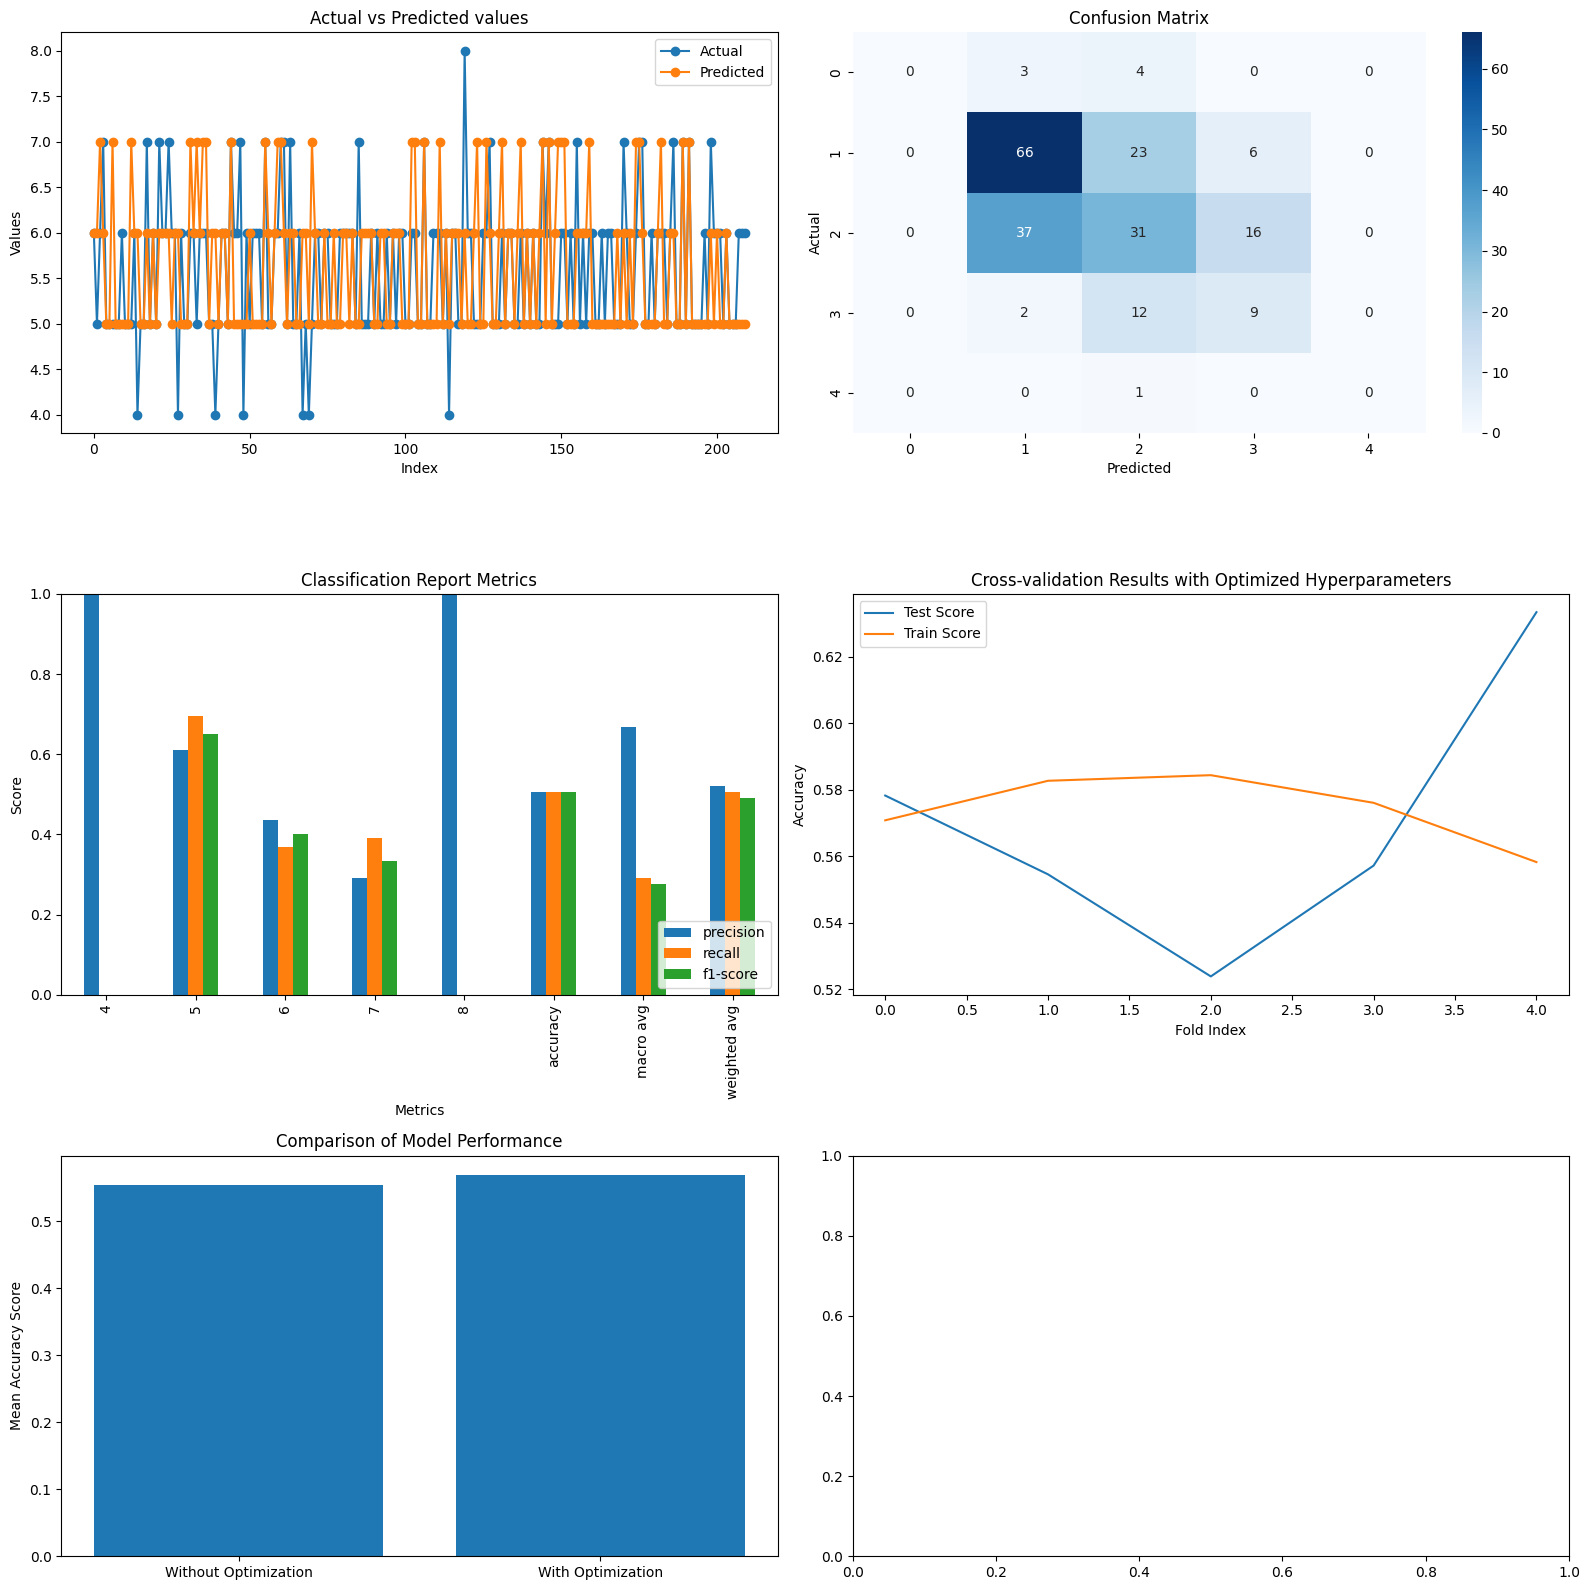

In [2043]:

def perform_hyperparameter_optimization(X_train: np.ndarray, y_train: np.ndarray, model: Any) -> Dict[str, Any]:
    param_grid = {
        'alpha': np.logspace(-3, 1, num=100),
        'binarize': np.linspace(0, 1, num=100),
        'class_prior': [None, np.random.dirichlet(np.ones(3), size=1)[0]],
        'fit_prior': [True, False],
        'force_alpha': [True, False]
    }
    best_params = optimize_hyperparameters(X_train, y_train, model, param_grid)
    logging.info(f"Best parameters: {best_params}")
    return best_params

def cross_validate_with_optimized_params(X_train: np.ndarray, y_train: np.ndarray, model: Any, best_params: Dict[str, Any]) -> Dict[str, Any]:
    cv_results = cross_validation_with_optimized_hyperparameters(X_train, y_train, model, best_params, model_name='BernoulliNB')
    logging.info(f"Cross-validation results: {cv_results}")
    return cv_results

def bernoulli_naive_bayes_main():
    try:
        # Initialize and split data
        X_train, X_test, y_train, y_test = initialize_and_split_data("standard", 'none')
        logging.info("Data initialization and splitting complete.")

        # Initial Model Evaluation
        bnb = BernoulliNB()
        mean_accuracy, X_fold_test, y_fold_test, y_pred, accuracy_scores = evaluate_initial_model(X_train, y_train, bnb)
        accuracy_without_optimization = mean_accuracy

        # Report Generation for the Last Fold
        report = generate_report(y_fold_test, y_pred)

        # Hyperparameter Tuning
        best_params = perform_hyperparameter_optimization(X_train, y_train, bnb)

        # Cross-validation with the optimized hyperparameters
        cv_results = cross_validate_with_optimized_params(X_train, y_train, bnb, best_params)
        accuracy_with_optimization = np.mean(cv_results['test_score'])

        # Display plots
        display_plots(y_fold_test, y_pred, report, cv_results, accuracy_without_optimization, accuracy_with_optimization)

    except Exception as e:
        logging.error("An error occurred during model evaluation and plotting.", exc_info=True)

if __name__ == "__main__":
    bernoulli_naive_bayes_main()

# Bernoulli Naive Bayes

2024-05-30 09:20:14,599 - INFO - X shape: (1503, 5), y shape: (1503,)
2024-05-30 09:20:14,599 - INFO - Data scaled using standard scaler.
2024-05-30 09:20:14,599 - INFO - Data initialization and splitting complete.
2024-05-30 09:20:14,609 - INFO - Accuracy for this fold: 59.24%
2024-05-30 09:20:14,615 - INFO - Accuracy for this fold: 60.19%
2024-05-30 09:20:14,615 - INFO - Accuracy for this fold: 55.24%
2024-05-30 09:20:14,622 - INFO - Accuracy for this fold: 51.90%
2024-05-30 09:20:14,625 - INFO - Accuracy for this fold: 50.48%
2024-05-30 09:20:14,626 - INFO - Mean accuracy score over all folds: 55.41%
2024-05-30 09:20:14,627 - INFO - Accuracy for the last fold: 50.48%
2024-05-30 09:20:14,644 - INFO - Classification report:
              precision    recall  f1-score   support

           4       1.00      0.00      0.00         7
           5       0.61      0.69      0.65        95
           6       0.44      0.37      0.40        84
           7       0.29      0.39      0.33     

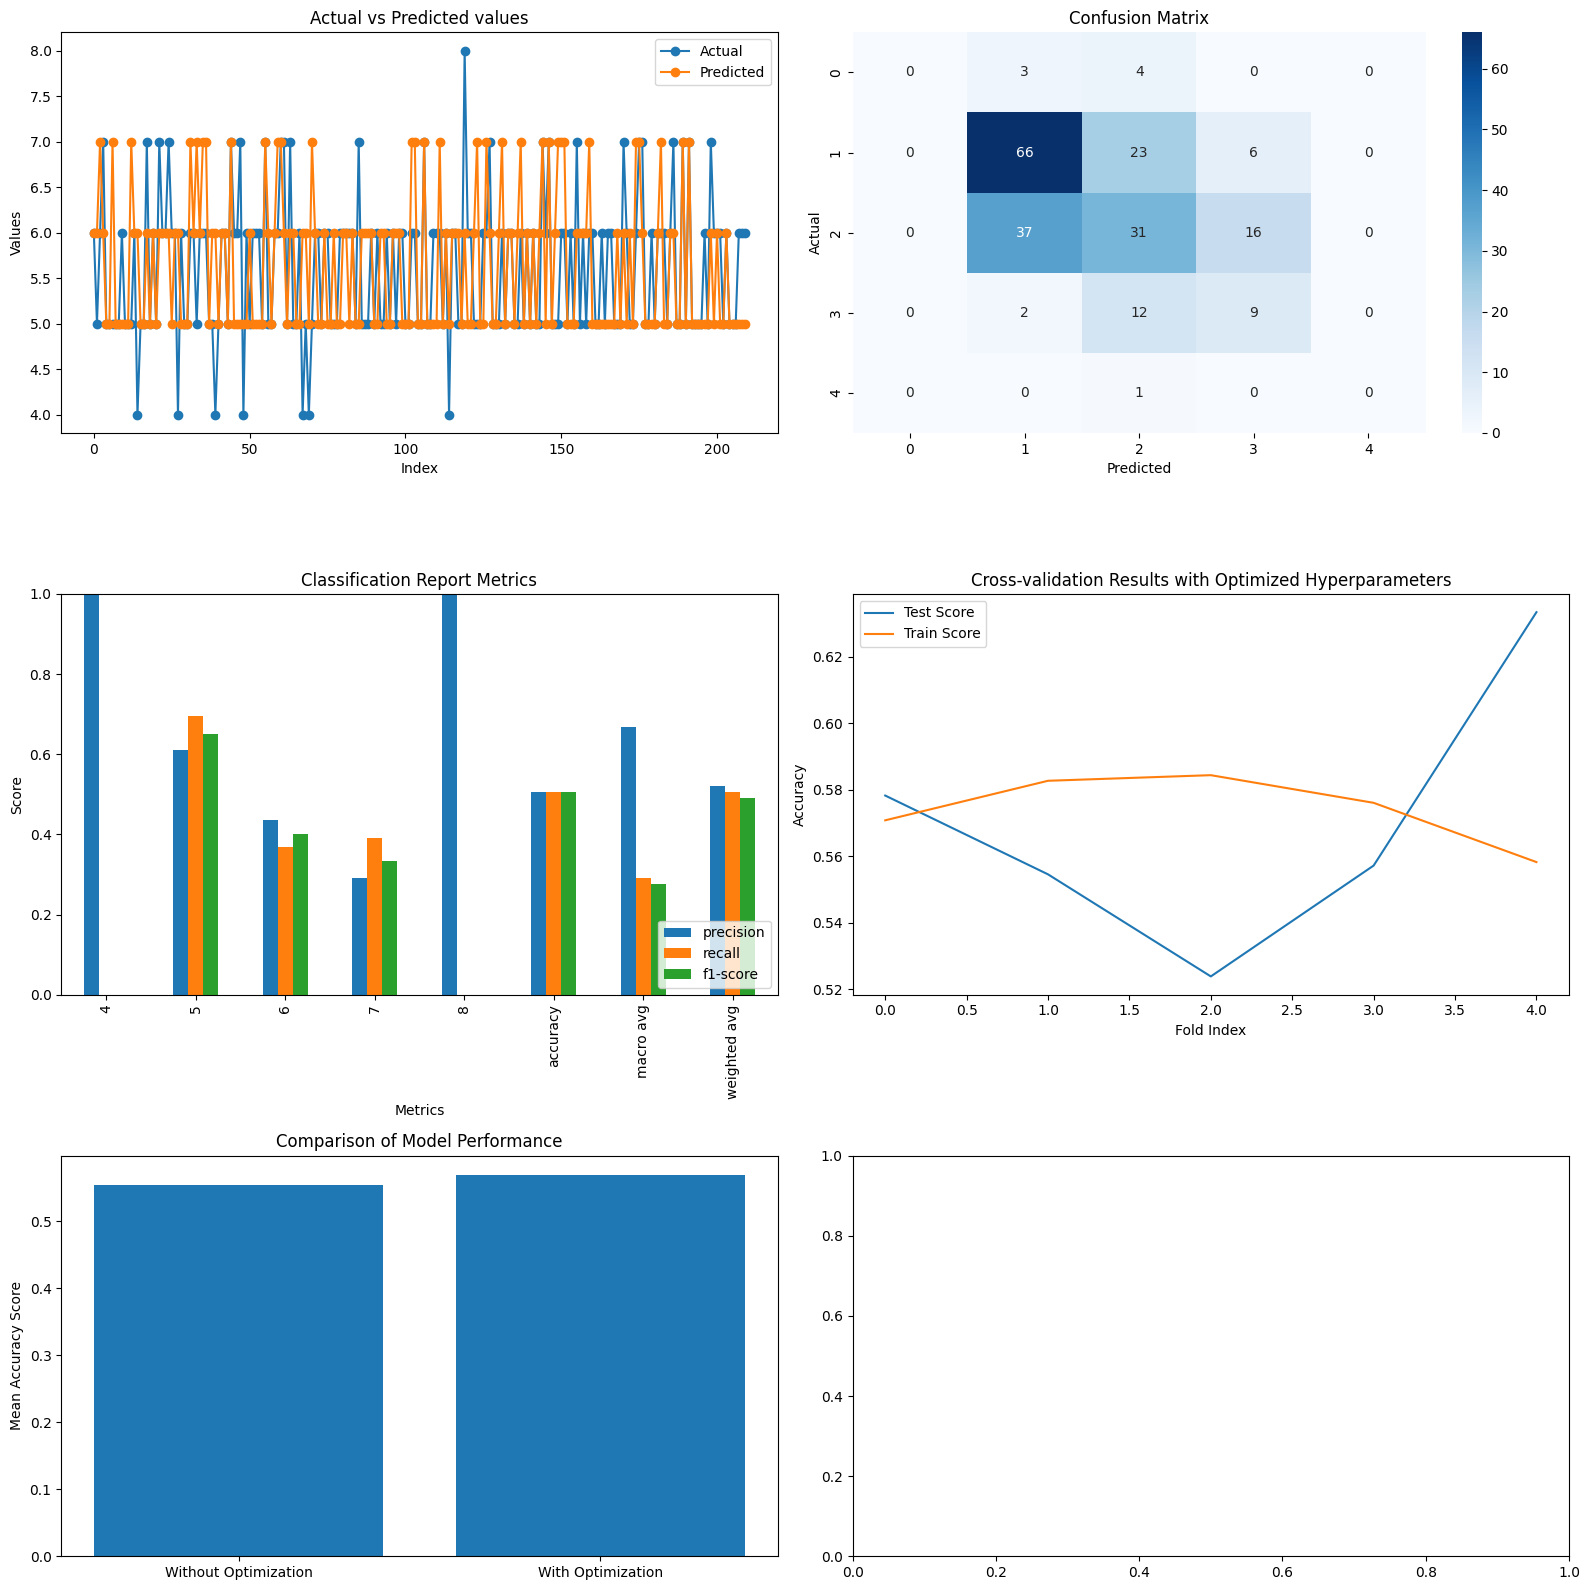

In [2044]:

def perform_hyperparameter_optimization(X_train: np.ndarray, y_train: np.ndarray, model: Any) -> Dict[str, Any]:
    param_grid = {
            'alpha': np.logspace(-3, 1, num=100),
            'binarize': np.linspace(0, 1, num=100),
            'class_prior': [None, np.random.dirichlet(np.ones(3), size=1)[0]],
            'fit_prior': [True, False],
            'force_alpha': [True, False]
        }
    best_strategy = optimize_hyperparameters(X_train, y_train, model, param_grid)
    logging.info(f"Best strategy: {best_strategy}")
    return best_strategy

def cross_validate_with_optimized_params(X_train: np.ndarray, y_train: np.ndarray, model: Any, best_params: Dict[str, Any]) -> Dict[str, Any]:
    cv_results = cross_validation_with_optimized_hyperparameters(X_train, y_train, model, best_params, model_name='BernoulliNB')
    logging.info(f"Cross-validation results: {cv_results}")
    return cv_results


def multinominal_naive_bayes_main():
    try:
        # Initialize and split data
        X_train, X_test, y_train, y_test = initialize_and_split_data("standard", 'none')
        logging.info("Data initialization and splitting complete.")

        # Initial Model Evaluation
        mnb = BernoulliNB()
        mean_accuracy, X_fold_test, y_fold_test, y_pred, accuracy_scores = evaluate_initial_model(X_train, y_train, mnb)
        accuracy_without_optimization = mean_accuracy

        # Report Generation for the Last Fold
        report = generate_report(y_fold_test, y_pred)

        # Hyperparameter Tuning
        best_strategy = perform_hyperparameter_optimization(X_train, y_train, mnb)

        # Cross-validation with the optimized hyperparameters
        cv_results = cross_validate_with_optimized_params(X_train, y_train, mnb, best_strategy)
        accuracy_with_optimization = np.mean(cv_results['test_score'])

        # Display plots
        display_plots(y_fold_test, y_pred, report, cv_results, accuracy_without_optimization, accuracy_with_optimization)

    except Exception as e:
        logging.error("An error occurred during model evaluation and plotting.", exc_info=True)

if __name__ == "__main__":
    multinominal_naive_bayes_main()